利用特征量和机器学习的方法中，特征量仍是由人工设计的，而在神经网络中，连
图像中包含的重要特征量也都是由机器来学习的。
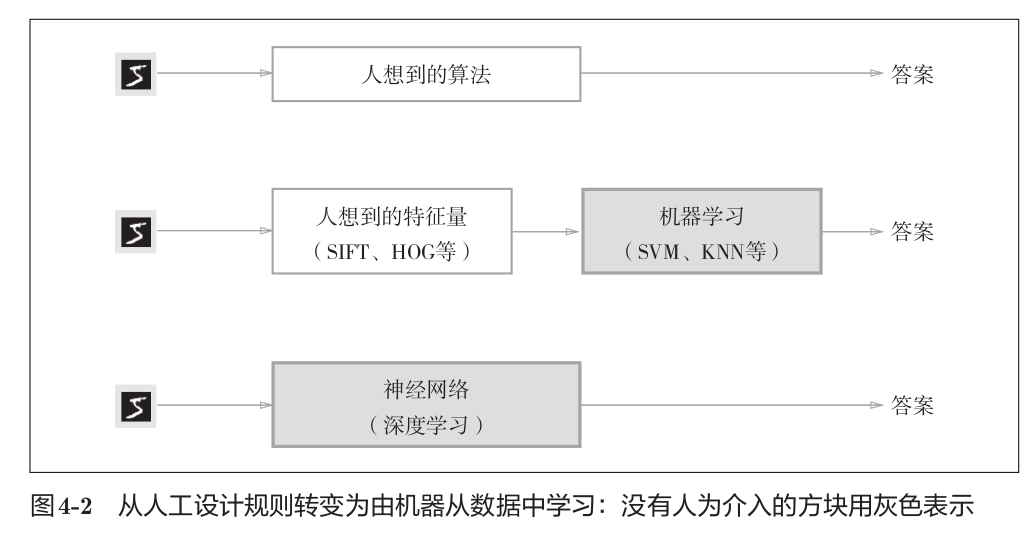

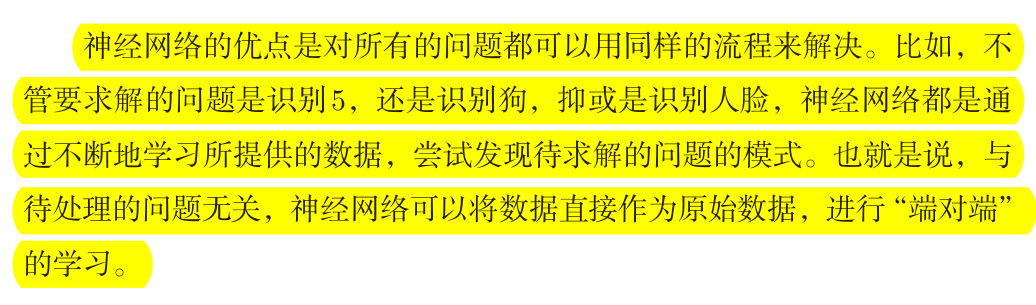

损失函数可以使用任意函数，但一般用均方误差和交叉熵误差等。
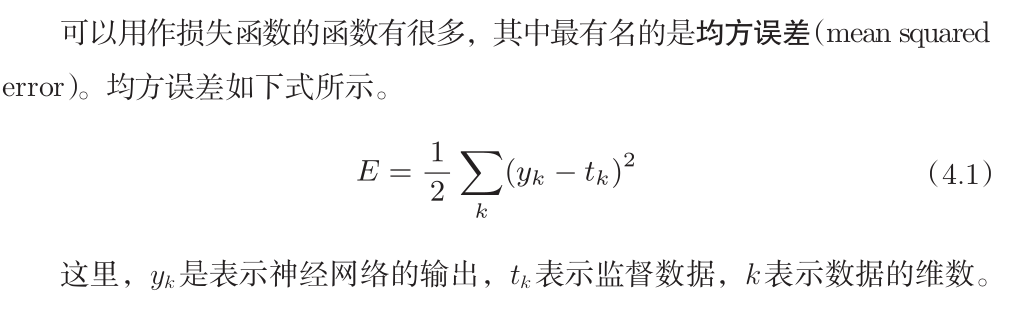

手写数字的例子

In [36]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from PIL import Image
import numpy as np

In [5]:
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
loss =0.5 * np.sum((np.array(y)-np.array(t))**2)
loss

0.09750000000000003

In [37]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

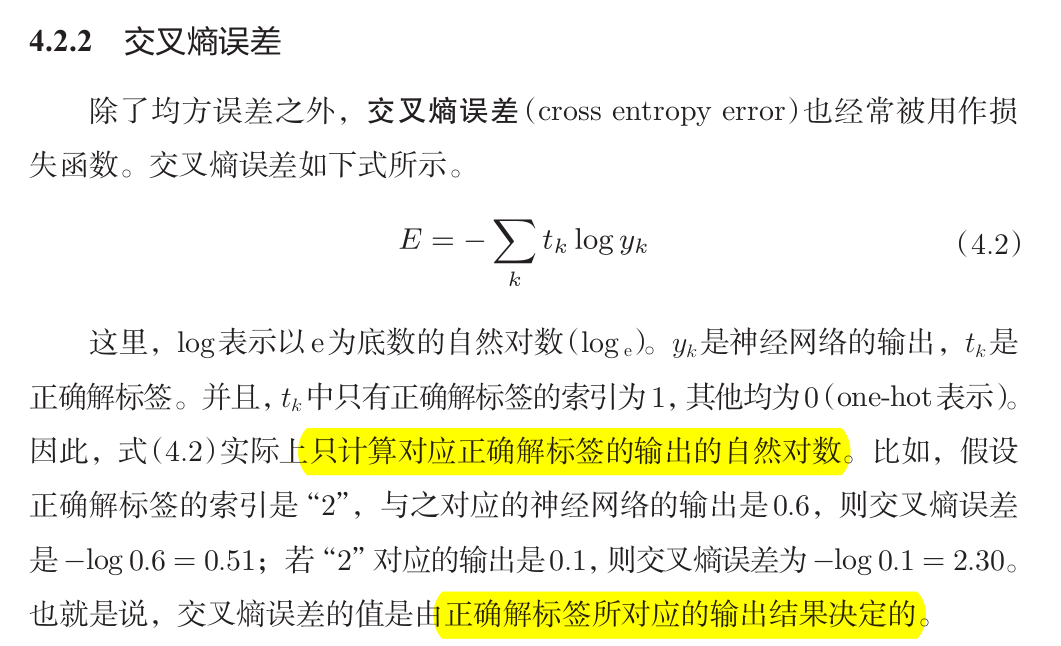

正确解标签对应的输出越大，式（4.2）的值越接近 0；当输出为 1 时，交叉熵
误差为 0。

适合输出为概率的模型，输出概率越大，且是正解，那么 E就越小。相反，输出概率小，但是是正解，E误差就大

In [38]:
def cross_entropy_error(y, t):
    delta = 1e-7 #当出现 np.log(0) 时，np.log(0) 会变为负无限大的 -inf
    return -1 * np.sum(t*np.log(y + delta))

前面介绍的损失函数的例子中考虑的都是针对单个数据的损失函数。如果要求所有训练数据的损失函数的总和，以交叉熵误差为例，可以写成下面
的式（4.3）。
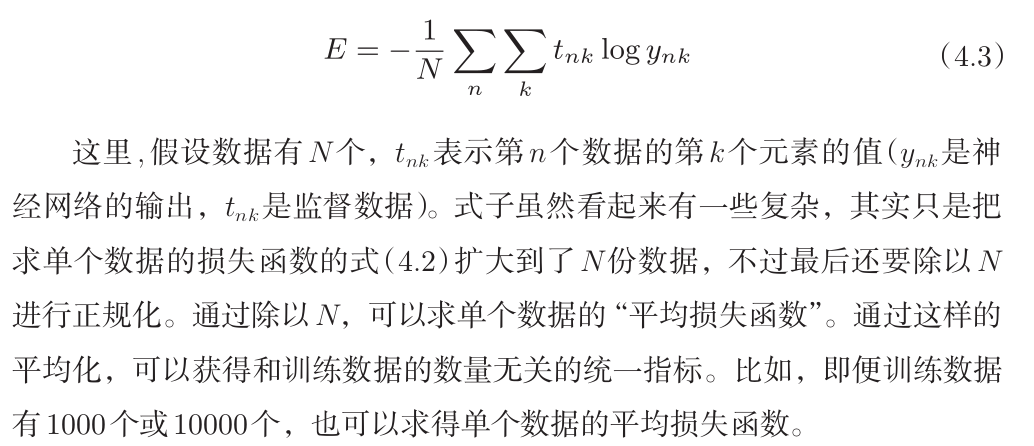

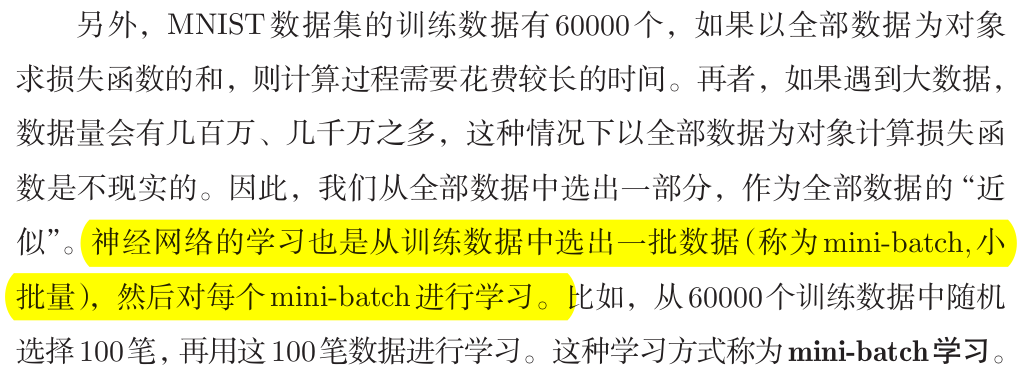

In [7]:
mnist = fetch_openml('mnist_784')
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=10000, shuffle=False)

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T

def _flatten(x):
    return x.reshape(28, 28)

def _normalize(x):
    return x / 255.0

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    (x_train, t_train), (x_test, t_test) = (X_train.to_numpy(), y_train.to_numpy()), (X_test.to_numpy(), y_test.to_numpy())
    
    t_train = t_train.astype(np.int32)
    t_test= t_test.astype(np.int32)
    if normalize:
        x_train = _normalize(x_train)
        x_test = _normalize(x_test)

    if not flatten:
        x_train = _flatten(x_train)
        x_test = _flatten(x_test)

    if one_hot_label:
        t_train = _change_one_hot_label(t_train)
        t_test = _change_one_hot_label(t_test)

    return (x_train, t_train), (x_test, t_test)

/home/frog/anaconda3/envs/learning_dl/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [9]:
np.random.choice(6000, 10)

array([4102,  955, 1940, 2423, 1206, 3753, 1091, 5188, 1281, 4513])

In [11]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

mini-batch 版交叉熵误差的实现

In [17]:
t = np.array([1])
t = t.reshape(1, t.size)
t.shape

(1, 1)

In [25]:
x = np.arange(12).reshape(3, 4)
t=np.array([1, 2, 3])
print([np.arange(3), t])
print(x[np.arange(3), t])
print(x[0, 1], x[1, 2], x[2, 3])

[array([0, 1, 2]), array([1, 2, 3])]
[ 1  6 11]
1 6 11


简单介绍一下 np.log( y[np.arange(batch_size), t] )。np.arange
(batch_size) 会生成一个从 0 到 batch_size-1 的数组。比如当batch_size 为 5时，np.arange(batch_size) 会生成一个 NumPy 数组 [0, 1, 2, 3, 4]。因为t 中标签是以 [2, 7, 0, 9, 4] 的形式存储的，所以 y[np.arange(batch_size),t] 能抽出各个数据的正确解标签对应的神经网络的输出（在这个例子中，y[np.arange(batch_size), t] 会 生 成 NumPy 数 组 [y[0,2], y[1,7], y[2,0],y[3,9], y[4,4]]）

交叉熵中要计算logy，因为非one-hot中，没有命中label的都是0*logy = 0，因此只要计算命中label的那个数字就行，1*logy = y中对应label的那个神经元，label = 0，1，… 8, 9， 当label等于2时计算 log y[batch_number, 2] 就行



In [ ]:
y[np.arange(batch_size), t]

In [39]:
# one hot
def cross_entropy_error(y, t):
    delta = 1e-7
    n = y.shape[0]
    return -np.sum(t*np.log(y+delta))/n

# not one hot, lable is like: 2, 3, 4
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

4.2.5
为何要设定损失函数

现在我们来关注这个神经网络中的某一个权重参
数。此时，对该权重参数的损失函数求导，表示的是“如果稍微改变这个权
重参数的值，损失函数的值会如何变化”。如果导数的值为负，通过使该权
重参数向正方向改变，可以减小损失函数的值；反过来，如果导数的值为正，
则通过使该权重参数向负方向改变，可以减小损失函数的值。

在进行神经网络的学习时，不能将识别精度作为指标。因为如果以
识别精度为指标，则参数的导数在绝大多数地方都会变为 0。

为了回答这个问题，我们来思考另一个具体例子。假设某个神经网络正
确识别出了 100 笔训练数据中的 32 笔，此时识别精度为 32 %。如果以识别精
度为指标，即使稍微改变权重参数的值，识别精度也仍将保持在 32 %，不会
出现变化。也就是说，仅仅微调参数，是无法改善识别精度的。即便识别精
度有所改善，它的值也不会像 32.0123 . . . % 这样连续变化，而是变为 33 %、
34 % 这样的不连续的、离散的值。而如果把损失函数作为指标，则当前损
失函数的值可以表示为 0.92543 . . . 这样的值。并且，如果稍微改变一下参数
的值，对应的损失函数也会像 0.93432 . . . 这样发生连续性的变化。
识别精度对微小的参数变化基本上没有什么反应，即便有反应，它的值
也是不连续地、突然地变化。作为激活函数的阶跃函数也有同样的情况。出
于相同的原因，如果使用阶跃函数作为激活函数，神经网络的学习将无法进行。
如图 4-4 所示，阶跃函数的导数在绝大多数地方（除了 0 以外的地方）均为 0。
也就是说，如果使用了阶跃函数，那么即便将损失函数作为指标，参数的微
小变化也会被阶跃函数抹杀，导致损失函数的值不会产生任何变化。
阶跃函数就像“竹筒敲石”一样，只在某个瞬间产生变化。而 sigmoid 函数，
如图 4-4 所示，不仅函数的输出（竖轴的值）是连续变化的，曲线的斜率（导数）
也是连续变化的。也就是说，sigmoid 函数的导数在任何地方都不为 0。这对
神经网络的学习非常重要。得益于这个斜率不会为 0 的性质，神经网络的学
习得以正确进行

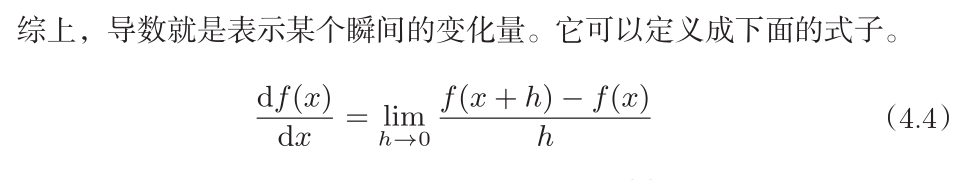

In [40]:
def numerical_diff(f, x):
    h = 1e-10
    return (f(x+h) - f(x-h)) / (2*h)


def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp = x[idx]
        x[idx] = tmp + h
        fxh1 = f(x)

        x[idx] = tmp - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp
    return grad

，梯度表示的是各点处的函数值减小最多的方向。因此，
无法保证梯度所指的方向就是函数的最小值或者真正应该前进的方向。实际
上，在复杂的函数中，梯度指示的方向基本上都不是函数值最小处。

。在梯度法中，函数的取值从当前位置沿着梯
度方向前进一定距离，然后在新的地方重新求梯度，再沿着新梯度方向前进，
如此反复，不断地沿梯度方向前进。像这样，通过不断地沿梯度方向前进，
逐渐减小函数值的过程就是梯度法（gradient method）

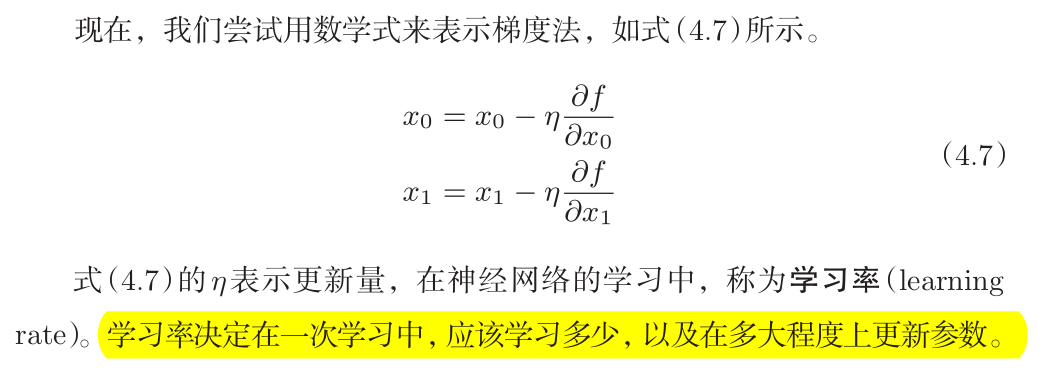

In [41]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    for step in range(step_num):
        x -= lr * numerical_gradient(f, x)
    return x

In [42]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x, lr=0.1)

array([-6.11110793e-10,  8.14814391e-10])

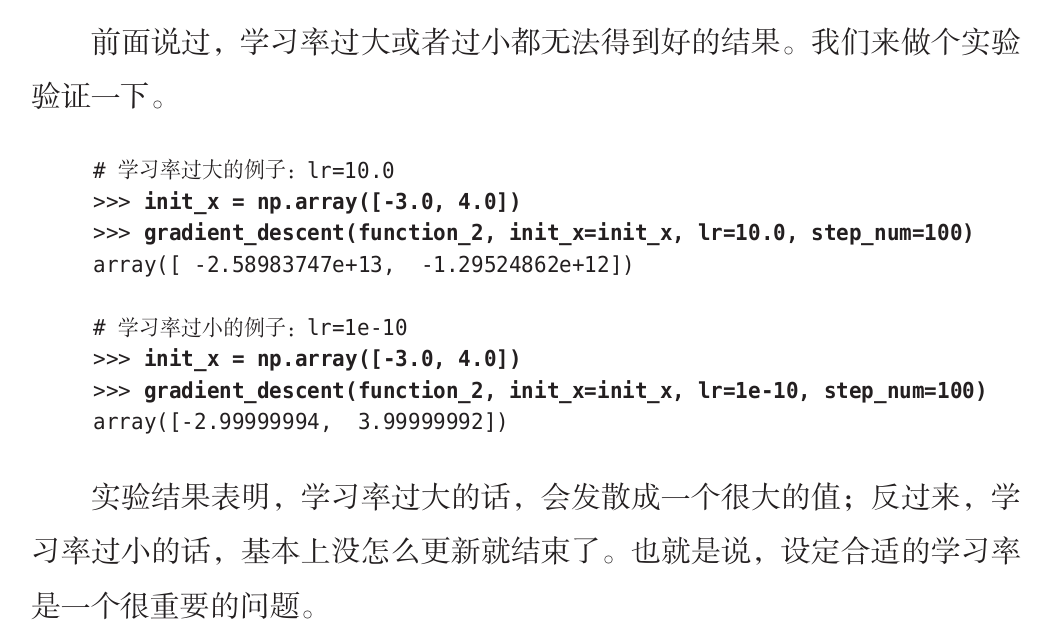

In [43]:
def softmax(x):
    c = np.max(x)
    return np.exp(x - c)/np.sum(np.exp(x - c))

In [45]:
import sys, os
sys.path.append(os.pardir)
import numpy as np

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # 用高斯分布进行初始化
    
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

注意下面的计算梯度的函数，只支持了2维，多维的计算还是比较麻烦的，需要层层递推

In [52]:
def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 还原值
        
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        
        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 还原值
        it.iternext()   
        
    return grad

In [53]:
net = simpleNet()
print(net.W)
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)
np.argmax(p) # 最大值的索引
t = np.array([0, 0, 1]) # 正确解标签
net.loss(x, t)
# 接下来求梯度
def f(W):
    return net.loss(x, t)
dw = numerical_gradient(f, net.W)
print(dw)

[[-0.0444667   0.39308105  1.66037027]
 [ 1.15833506 -0.92322092 -0.70728658]]
[ 1.01582153 -0.5950502   0.35966424]
[[-0.15260847 -0.39082136  0.54342983]
 [-0.22891271 -0.58623204  0.81514475]]


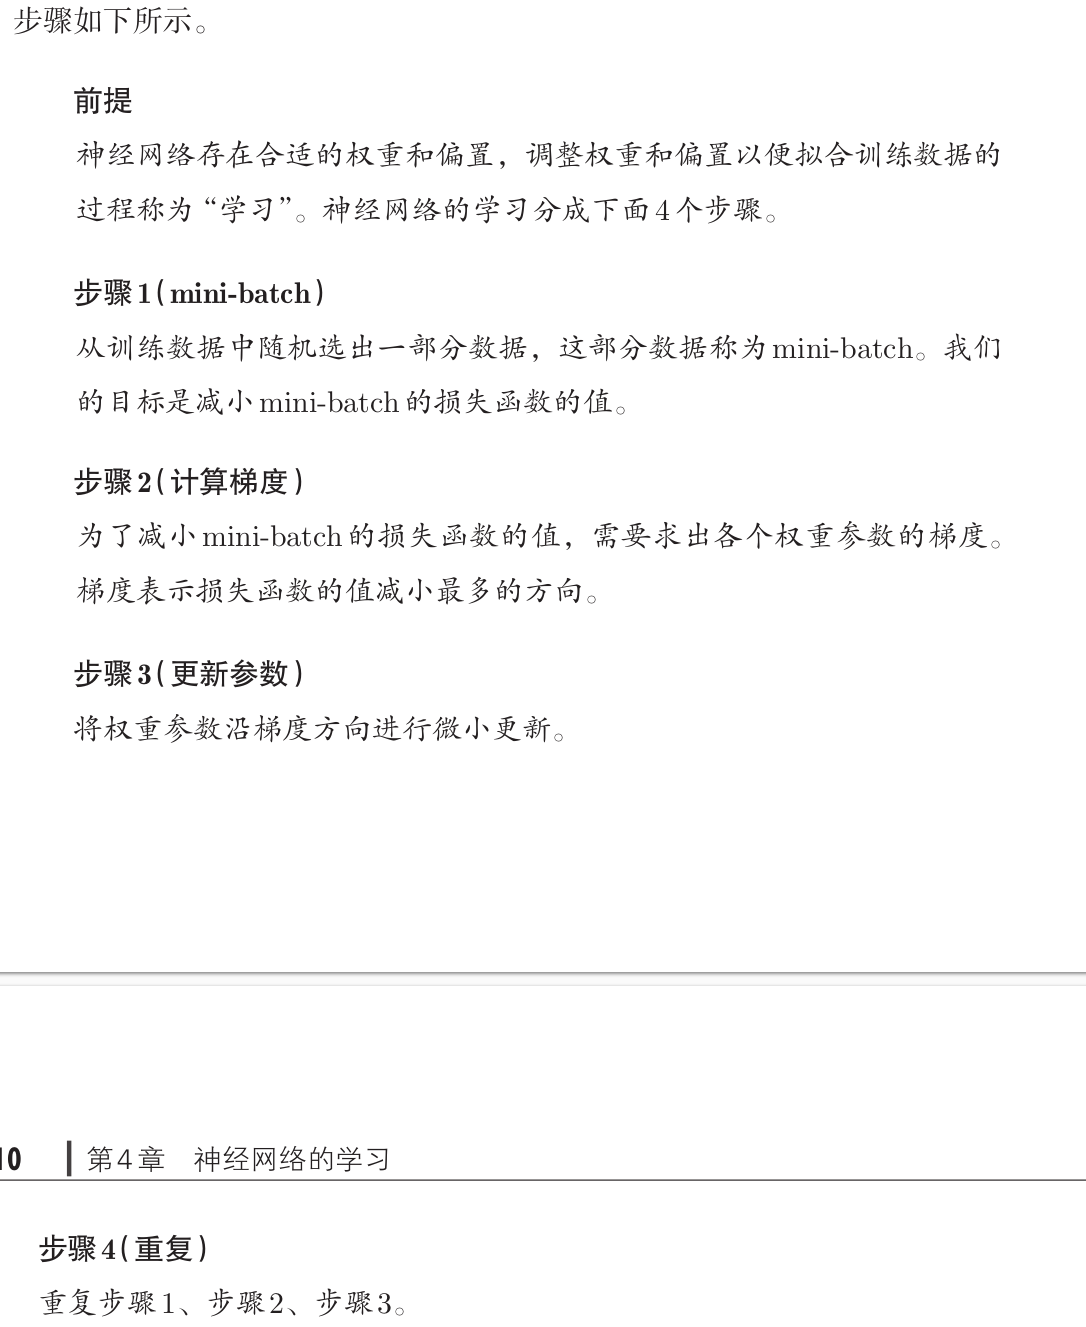

不过因为这里使用的数据是随机选择的 mini batch 数据，所以又称为
随机梯度下降法（stochastic gradient descent）。“随机”指的是“随机选择的”
的意思，因此，随机梯度下降法是“对随机选择的数据进行的梯度下降法”。
深度学习的很多框架中，随机梯度下降法一般由一个名为 SGD 的函数来实现。
SGD 来源于随机梯度下降法的英文名称的首字母。

2 层神经网络，使用 MNIST 数据集进行学习

In [60]:
def sigmod(x):
    return 1 / 1 + np.exp(-x)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,
        weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * \
        np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
        np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def predict(self, x):
        a1 = np.dot(x, self.params['W1']) + self.params['b1']
        z1 = sigmod(a1)
        a2 = np.dot(z1, self.params['W2']) + self.params['b2']
        y = softmax(a2)
        return y

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads

    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
net.params['W1'].shape # (784, 100)
net.params['b1'].shape # (100,)
net.params['W2'].shape # (100, 10)
net.params['b2'].shape # (10,)

x = np.random.rand(100, 784) # 伪输入数据（100 笔）
y = net.predict(x)

In [61]:
x = np.random.rand(100, 784) # 伪输入数据（100 笔）
t = np.random.rand(100, 10) # 伪正确解标签（100 笔）
grads = net.numerical_gradient(x, t)
grads['W1'].shape
grads['b1'].shape
grads['W2'].shape
grads['b2'].shape
# 计算梯度
# (784, 100)
# (100,)
# (100, 10)
# (10,)

(10,)

mini-batch 的实现

In [62]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label = True)
train_loss_list = []
# 超参数
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
for i in range(iters_num):
    # 获取 mini-batch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 计算梯度
    grad = network.numerical_gradient(x_batch, t_batch)
    # grad = network.gradient(x_batch, t_batch) # 高速版 !
    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    # 记录学习过程
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

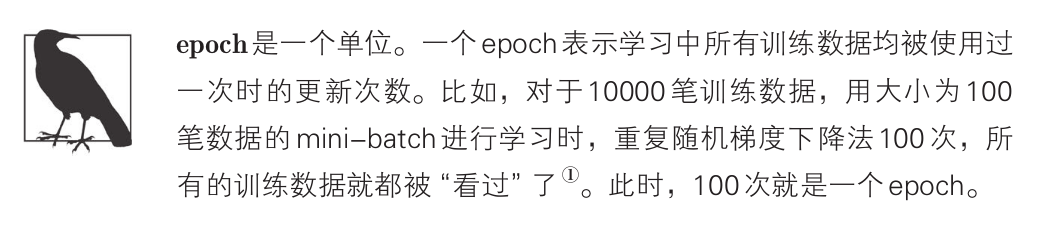

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label = True)

iters_num = 10000  # 适当设定循环的次数
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
for i in range(iters_num):
    # 获取 mini-batch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 计算梯度
    grad = network.numerical_gradient(x_batch, t_batch)
    # grad = network.gradient(x_batch, t_batch) # 高速版 !
    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    # 记录学习过程
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

In [ ]:
import matplotlib.pyplot as plt

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()